In [1]:
import boto3
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt; plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from IPython.display import clear_output

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'ryan-greiner-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'predictive_analytics/Data-Mining-Cup/train.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading CSV file
train = pd.read_csv(file_content_stream, delimiter = '|')

## Defining the file to be read from s3 bucket
file_key_2 = 'predictive_analytics/Data-Mining-Cup/test.csv'
bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading CSV file
test = pd.read_csv(file_content_stream_2, delimiter = '|')
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [2]:
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


# EDA

In [3]:
print('training size:', train.shape[0])
print('testing size:', test.shape[0])

training size: 1879
testing size: 498121


In [4]:
train['fraud'].value_counts() / train.shape[0]

0    0.944651
1    0.055349
Name: fraud, dtype: float64

Approximately $94.5\%$ of the observations are not fraud, while approximately $5.5\%$ of observations are fraud

<AxesSubplot: xlabel='trustLevel', ylabel='Count'>

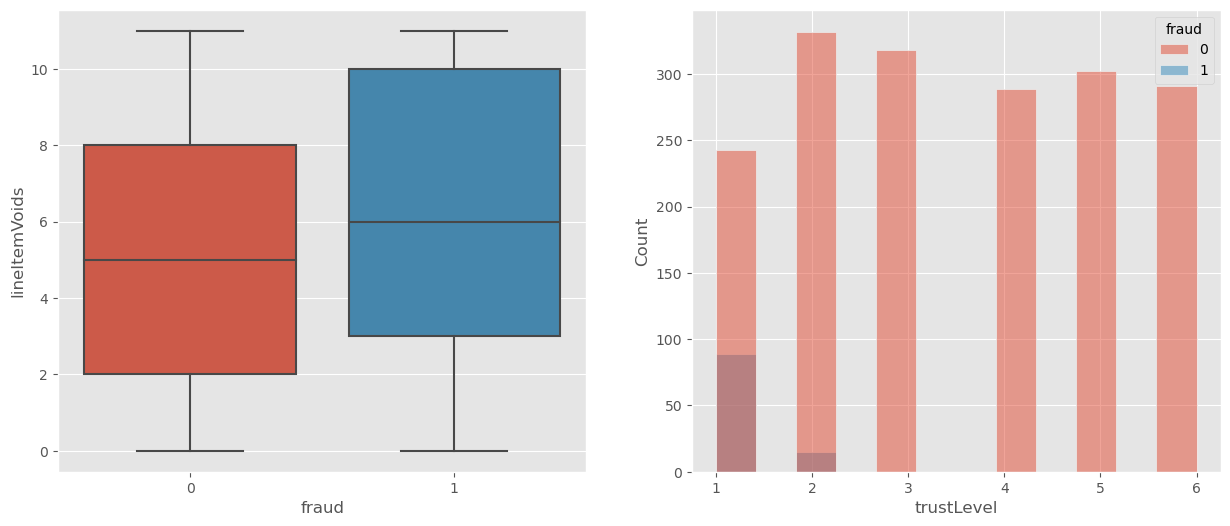

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], x = 'fraud', y = 'lineItemVoids', data = train)
sns.histplot(ax = axes[1], x = 'trustLevel', hue = 'fraud', fill = True, data = train)

<dl>
    <dt>Summary of Visuals</dt>
    <dd>As shown in the boxplot above, we can expect a transaction with more line item voids to have a higher likely hood of being fraudulent.</dd>
    <dd>We can also see from the bar chart that transactions with a lower trust level are much more likely to be fraudulent</dd>
</dl>

# Random Forest Importances

In [6]:
## Define Variables ##
X = train.drop(columns = 'fraud', axis = 1)
Y = train['fraud']

rf_importance = list()

for i in range(5):
    print(i)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Random Forest Importances ##
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
    rf_importance.append(rf_md.feature_importances_)
    clear_output()
    

imp_data = pd.DataFrame(rf_importance)

importances = pd.DataFrame({
    'Variable': X.columns.values,
    'Importance': np.nan
})

for i in range(len(X.columns.values)):
    importances.loc[i, 'Importance'] = np.mean(imp_data[i])

importances.sort_values(['Importance'], ascending = False, inplace = True)
importances

,Variable,Importance
0,trustLevel,0.438307
6,scannedLineItemsPerSecond,0.150548
8,lineItemVoidsPerPosition,0.115536
1,totalScanTimeInSeconds,0.110615
7,valuePerSecond,0.064811
3,lineItemVoids,0.047170
2,grandTotal,0.046796
4,scansWithoutRegistration,0.022475
5,quantityModifications,0.003741


Based on the importances found above, I will use the following variables in my modeling process: 
- trustLevel
- scannedLineItemsPerSecond
- totalScanTimeInSeconds
- lineItemVoidsPerPosition
- valuePerSecond

# Modeling

### Random Forest

In [7]:
X = train[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Random Forest Model ##
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predictions ##
rf_pred = rf_md.predict_proba(X_test)[:, 1]

## Calculate Metric ##
precision, recall, threshold = precision_recall_curve(Y_test, rf_pred)

## Ensure lists are the same length ##
print(len(precision), len(recall), len(threshold))

353 353 352


In [8]:
## Lists are different lengths, drop the last value from precision and recall ##
precision = np.delete(precision, len(precision)-1)
recall = np.delete(recall, len(recall)-1)
print(len(precision), len(recall), len(threshold))

352 352 352


In [9]:
# Create Data Frame for results ##
cutoffs = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': threshold})

## Euclidean Distance ##
cutoffs['Euclidean_distance'] = np.sqrt((1 - cutoffs['precision'])**2 + (1 - cutoffs['recall'])**2)
cutoffs = cutoffs.sort_values(by = 'Euclidean_distance')
cutoffs

,precision,recall,threshold,Euclidean_distance
322,0.466667,0.666667,0.213505,0.628932
321,0.451613,0.666667,0.204459,0.641747
325,0.481481,0.619048,0.269423,0.643418
320,0.437500,0.666667,0.199395,0.653848
324,0.464286,0.619048,0.246541,0.657354
...,...,...,...,...
3,0.056452,1.000000,0.000509,0.943548
2,0.056300,1.000000,0.000377,0.943700
1,0.056000,1.000000,0.000217,0.944000
0,0.055851,1.000000,0.000148,0.944149


In [10]:
rf_labels = np.where(rf_pred < .213505, 0, 1)
print(classification_report(Y_test, rf_labels))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       355
           1       0.45      0.62      0.52        21

    accuracy                           0.94       376
   macro avg       0.71      0.79      0.74       376
weighted avg       0.95      0.94      0.94       376



<dl>
  <dt>Random Forest Results</dt>
  <dd>Based on the results above, the best cutoff value for my random forest model is $.213505$</dd>
    <dd> This value still did not give a very high precision and recall for the $1$s, so some tuning would be necessary. </dd>
</dl>

### Ada Boost

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Ada Boost Model ##
ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), 
                                    n_estimators = 500, learning_rate = .01).fit(X_train, Y_train)

## Predictions ##
ada_pred = ada_md.predict_proba(X_test)[:, 1]

## Calculate Metric ##
precision, recall, threshold = precision_recall_curve(Y_test, ada_pred)
print(len(precision), len(recall), len(threshold))

350 350 349


In [12]:
precision = np.delete(precision, len(precision)-1)
recall = np.delete(recall, len(recall)-1)
print(len(precision), len(recall), len(threshold))

349 349 349


In [13]:
# Create Data Frame for results ##
cutoffs = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': threshold})

## Euclidean Distance ##
cutoffs['Euclidean_distance'] = np.sqrt((1 - cutoffs['precision'])**2 + (1 - cutoffs['recall'])**2)
cutoffs = cutoffs.sort_values(by = 'Euclidean_distance')
cutoffs

,precision,recall,threshold,Euclidean_distance
328,0.809524,0.809524,0.270287,0.269374
327,0.772727,0.809524,0.251189,0.296537
329,0.800000,0.761905,0.483858,0.310949
326,0.739130,0.809524,0.189805,0.323008
325,0.708333,0.809524,0.181952,0.348354
...,...,...,...,...
3,0.056300,1.000000,0.000013,0.943700
2,0.056150,1.000000,0.000012,0.943850
1,0.056000,1.000000,0.000002,0.944000
0,0.055851,1.000000,0.000002,0.944149


In [15]:
ada_labels = np.where(ada_pred < .269374, 0, 1)
print(classification_report(Y_test, ada_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       355
           1       0.81      0.81      0.81        21

    accuracy                           0.98       376
   macro avg       0.90      0.90      0.90       376
weighted avg       0.98      0.98      0.98       376



<dl>
    <dt>Ada Boost Results</dt>
    <dd>Based on the results above, the best cutoff value for my Ada boost model is $.274862$</dd>
    <dd>This value gave a slightly better precision and recall for the $0$s, while it gave a much better precesion and recall for the $1$s.</dd>
    <dd>The ada boost model is the one that should be used to predict customer fraud.<dd>
</dl>